In [8]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from libpysal import weights
import networkx as nx

# reset plt style
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# set home directory
os.chdir(
    'C:\\Users\\joche\\FIM Kernkompetenzzentrum\\Paper Agent-based Modeling - Dokumente\\General\\04 ABM\\03_data\\tetraeder_solar')
geo_gis_folder_path = 'C:\\Users\\joche\\FIM Kernkompetenzzentrum\\Paper Agent-based Modeling - Dokumente\\General\\04 ABM\\03_data\\tetraeder_solar\\'

In [3]:
gpd.read_file(geo_gis_folder_path + '20220815_0833_kreis_ingolstadt_buildings_export.shp')

,HID,STREET,NUMBER,ADDITION,ZIPCODE,CITY,AREA,AREA3D,PV,ST,geometry
0,59140,None,NaN,None,85049,Ingolstadt,52.49360,84.825564,2,2,"POLYGON ((672958.850 5402251.440, 672955.260 5..."
1,24600,None,NaN,None,85049,Ingolstadt,15.73105,22.582933,0,2,"POLYGON ((675080.760 5404866.570, 675080.750 5..."
2,11491,None,NaN,None,85055,Ingolstadt,21.72365,45.749336,0,2,"POLYGON ((676460.340 5408792.430, 676459.200 5..."
3,19930,None,NaN,None,85049,Ingolstadt,21.60955,67.919940,0,0,"POLYGON ((676433.560 5404238.540, 676432.810 5..."
4,1091,None,NaN,None,85055,Ingolstadt,18.62445,32.003295,0,2,"POLYGON ((680133.790 5406419.340, 680133.370 5..."
...,...,...,...,...,...,...,...,...,...,...,...
66654,35500,Ewald-Kluge-Str.,2.0,None,85057,Ingolstadt,595.36010,1451.094979,2,2,"POLYGON ((677762.940 5405585.900, 677763.310 5..."
66655,35510,Annette-Kolb-Str.,7.0,None,85055,Ingolstadt,112.36525,307.930714,2,2,"POLYGON ((679058.260 5406013.470, 679056.610 5..."
66656,35522,Regimentstr.,8.0,None,85051,Ingolstadt,647.60040,1240.483057,2,2,"POLYGON ((678772.570 5403496.560, 678777.420 5..."
66657,35524,Lortzingstr.,1.0,None,85057,Ingolstadt,735.83455,1503.673231,1,1,"POLYGON ((677355.170 5405601.340, 677354.750 5..."


In [4]:
# read in shapefiles
buildings_gdf = gpd.read_file('20220815_0833_kreis_ingolstadt_buildings_export.shp')
roofs_gdf = gpd.read_file('20220815_0833_kreis_ingolstadt_roofs_export.shp')
# insert centroid position with lat/lon reference system
#buildings_gdf['building_centroid_epsg_4326'] = buildings_gdf.centroid.to_crs(4326)

In [5]:
# get centroid coordinates for an address in the dataset
def get_address_coordinates(buildings_gdf, streetname, streetnr):
    if len(buildings_gdf[(buildings_gdf.STREET == streetname) & (buildings_gdf.NUMBER == streetnr)]) == 0:
        return None
    else:
        building = buildings_gdf[(buildings_gdf.STREET == streetname) & (buildings_gdf.NUMBER == streetnr)]
        return building.centroid.x.values[0], building.centroid.y.values[0]

In [6]:
# filter building gdf by four addresses
def filter_space_by_addresses(building_gdf, lower_left, upper_left, upper_right, lower_right, margin_pct=0.00):
    xs, ys = [], []
    # check if addresses are valid
    for address in [lower_left, upper_left, upper_right, lower_right]:
        if get_address_coordinates(building_gdf, streetname=address[0], streetnr=address[1]) is None:
            print(f'invalid address: {address[0], address[1]}')
            return None
        else:

            address_coords = get_address_coordinates(building_gdf, streetname=address[0], streetnr=address[1])
            xs.append(address_coords[0])
            ys.append(address_coords[1])
    # filter by min/max of xs (left/right) and ys (top/bottom), accounting for an optional margin
    top, bottom, left, right = max(ys), min(ys), min(xs), max(xs)
    y_delta, x_delta = top - bottom, right - left
    gdf_filtered = building_gdf[(building_gdf.centroid.y >= (bottom - y_delta * margin_pct)) &  # bottom
                                (building_gdf.centroid.y <= (top + y_delta * margin_pct)) &  # top
                                (building_gdf.centroid.x >= (left - x_delta * margin_pct)) &  # left
                                (building_gdf.centroid.x <= (right + x_delta * margin_pct))]  # right
    return gdf_filtered

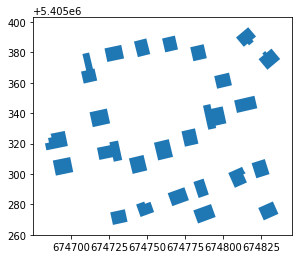

25 buildings


In [7]:
buildings_quarter_gdf = filter_space_by_addresses(buildings_gdf,
                                                  lower_left=('Immelstr.', 9), upper_left=('Immelstr.', 8),
                                                  upper_right=('Pappelweg', 4), lower_right=('Altenhofstr.', 33),
                                                  margin_pct=-0.03)
# plot buildings with a valid address
buildings_quarter_gdf[buildings_quarter_gdf.STREET.isnull() == False].plot()
plt.show()
print(f'{len(buildings_quarter_gdf[buildings_quarter_gdf.STREET.isnull() == False])} buildings')

In [9]:
# show valid buildings as list
buildings_quarter_gdf = buildings_quarter_gdf[buildings_quarter_gdf.STREET.isnull() == False]
buildings_quarter_gdf

,HID,STREET,NUMBER,ADDITION,ZIPCODE,CITY,AREA,AREA3D,PV,ST,geometry
3250,27857,Altenhofstr.,52.0,b,85049,Ingolstadt,89.65535,298.784077,2,2,"POLYGON ((674816.570 5405396.440, 674816.660 5..."
4979,12660,Erlenweg,6.0,None,85049,Ingolstadt,104.73460,200.461068,2,2,"POLYGON ((674763.650 5405287.330, 674769.980 5..."
5415,13172,Altenhofstr.,37.0,None,85049,Ingolstadt,84.95100,253.193358,2,2,"POLYGON ((674796.150 5405356.020, 674794.230 5..."
6147,13206,Erlenweg,8.0,None,85049,Ingolstadt,98.73645,204.536951,2,2,"POLYGON ((674815.720 5405294.410, 674807.810 5..."
6389,12627,Altenhofstr.,52.0,None,85049,Ingolstadt,101.88845,332.331651,2,2,"POLYGON ((674837.600 5405375.550, 674829.170 5..."
8927,12665,Erlenweg,2.0,None,85049,Ingolstadt,82.64380,138.809055,2,2,"POLYGON ((674736.870 5405270.320, 674737.250 5..."
13290,13208,Erlenweg,10.0,None,85049,Ingolstadt,94.43170,191.394786,1,1,"POLYGON ((674818.800 5405307.050, 674827.470 5..."
16381,12611,Altenhofstr.,45.0,None,85049,Ingolstadt,102.20035,317.056431,2,2,"POLYGON ((674733.090 5405384.810, 674733.380 5..."
16621,12681,Immelstr.,8.0,None,85049,Ingolstadt,123.46055,296.988163,2,2,"POLYGON ((674715.530 5405369.290, 674717.320 5..."
16634,12697,Lärchenweg,16.0,None,85049,Ingolstadt,93.85790,226.261530,2,2,"POLYGON ((674823.190 5405277.630, 674832.790 5..."


In [15]:
# filter buildings
relevant_hids = [12588,
                 12593,
                 12611,
                 12649,
                 12676,
                 12677,
                 12681,
                 13172,
                 13178,
                 13179,
                 13205,
                 13212,
                 13251]
buildings_quarter_gdf = buildings_quarter_gdf[buildings_quarter_gdf['HID'].isin(relevant_hids)]
buildings_quarter_gdf

,HID,STREET,NUMBER,ADDITION,ZIPCODE,CITY,AREA,AREA3D,PV,ST,geometry
5415,13172,Altenhofstr.,37.0,None,85049,Ingolstadt,84.95100,253.193358,2,2,"POLYGON ((674796.150 5405356.020, 674794.230 5..."
16381,12611,Altenhofstr.,45.0,None,85049,Ingolstadt,102.20035,317.056431,2,2,"POLYGON ((674733.090 5405384.810, 674733.380 5..."
16621,12681,Immelstr.,8.0,None,85049,Ingolstadt,123.46055,296.988163,2,2,"POLYGON ((674715.530 5405369.290, 674717.320 5..."
24731,12588,Erlenweg,3.0,None,85049,Ingolstadt,119.87465,308.463556,1,1,"POLYGON ((674757.400 5405308.890, 674754.610 5..."
44902,13251,Altenhofstr.,35.0,None,85049,Ingolstadt,115.13215,258.579663,2,2,"POLYGON ((674820.650 5405351.380, 674822.550 5..."
53334,13205,Erlenweg,5.0,None,85049,Ingolstadt,93.78760,220.587022,2,2,"POLYGON ((674783.840 5405319.910, 674774.980 5..."
53344,13212,Erlenweg,7.0,None,85049,Ingolstadt,167.11485,426.362113,2,2,"POLYGON ((674799.770 5405344.420, 674800.800 5..."
61536,12676,Immelstr.,4.0,None,85049,Ingolstadt,146.65540,417.472262,2,2,"POLYGON ((674727.570 5405311.020, 674718.750 5..."
61781,12593,Erlenweg,1.0,None,85049,Ingolstadt,102.85365,295.244480,1,2,"POLYGON ((674747.750 5405312.490, 674750.200 5..."
61801,12649,Altenhofstr.,43.0,None,85049,Ingolstadt,88.62070,253.138262,1,1,"POLYGON ((674749.580 5405389.100, 674752.170 5..."


In [16]:
# combine building gdf with roofs gdf
def merge_buildings_with_roofs(buildings_gdf_quarter, roofs_gdf):
    buildings_roofs_gdf_quarter = pd.merge(roofs_gdf, buildings_gdf_quarter, on='HID')
    # rename cols
    buildings_roofs_gdf_quarter.rename(
        columns={'AREA3D_x': 'AREA3D_roof', 'PV_x': 'PV_roof', 'ST_x': 'ST_roof', 'geometry_x': 'geometry_roof',
                 'AREA3D_y': 'AREA3D_building', 'PV_y': 'PV_building', 'ST_y': 'ST_building',
                 'geometry_y': 'geometry_building'}, inplace=True)
    return buildings_roofs_gdf_quarter

In [17]:
buildings_roofs_quarter_gdf = merge_buildings_with_roofs(buildings_quarter_gdf, roofs_gdf)
buildings_roofs_quarter_gdf

,HID,AREA3D_roof,GLOBAL,DIFFUSE,DIRECT,KWHPA,TILT,ASPECT,PV_roof,ST_roof,...,STREET,NUMBER,ADDITION,ZIPCODE,CITY,AREA,AREA3D_building,PV_building,ST_building,geometry_building
0,12681,1.471532,575.127502,248.819260,326.307861,748.0,46.187435,-12.655476,0,0,...,Immelstr.,8.0,None,85049,Ingolstadt,123.46055,296.988163,2,2,"POLYGON ((674715.530 5405369.290, 674717.320 5..."
1,12681,2.979048,513.515930,241.284363,272.231659,1452.0,46.187435,-12.655476,0,0,...,Immelstr.,8.0,None,85049,Ingolstadt,123.46055,296.988163,2,2,"POLYGON ((674715.530 5405369.290, 674717.320 5..."
2,12681,9.043612,744.685730,280.918365,463.767395,6824.0,48.122799,76.200489,0,0,...,Immelstr.,8.0,None,85049,Ingolstadt,123.46055,296.988163,2,2,"POLYGON ((674715.530 5405369.290, 674717.320 5..."
3,12681,33.897263,368.363922,232.964447,135.399521,12371.0,46.187435,-12.655476,0,0,...,Immelstr.,8.0,None,85049,Ingolstadt,123.46055,296.988163,2,2,"POLYGON ((674715.530 5405369.290, 674717.320 5..."
4,12681,3.477198,1148.961792,335.273590,813.688049,4016.0,48.527089,166.922314,0,0,...,Immelstr.,8.0,None,85049,Ingolstadt,123.46055,296.988163,2,2,"POLYGON ((674715.530 5405369.290, 674717.320 5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,13251,66.263748,1283.551147,340.432770,943.118408,85445.0,28.793718,166.171749,2,2,...,Altenhofstr.,35.0,None,85049,Ingolstadt,115.13215,258.579663,2,2,"POLYGON ((674820.650 5405351.380, 674822.550 5..."
81,13178,56.272747,943.928955,306.236664,637.692322,53303.0,49.575877,-102.756738,1,1,...,Altenhofstr.,41.0,None,85049,Ingolstadt,80.23520,257.665668,1,1,"POLYGON ((674770.420 5405381.840, 674762.040 5..."
82,13178,54.635891,789.715576,282.418030,507.297577,43558.0,49.547890,77.831764,7,0,...,Altenhofstr.,41.0,None,85049,Ingolstadt,80.23520,257.665668,1,1,"POLYGON ((674770.420 5405381.840, 674762.040 5..."
83,13179,59.783794,975.844788,308.571533,667.273254,59043.0,47.022008,-103.144287,1,1,...,Altenhofstr.,39.0,None,85049,Ingolstadt,85.14620,208.930401,1,1,"POLYGON ((674780.540 5405374.090, 674778.460 5..."


In [27]:
# create df for model export with aggregated roof pv capacity
export = buildings_roofs_quarter_gdf.groupby(['HID']).apply(
    lambda x: x[(x['PV_roof'] == 1) | (x['PV_roof'] == 2)][['AREA3D_roof', 'GLOBAL']].sum())
export['ANNUAL_RADIATION_kWh'] = export['AREA3D_roof'] * export['GLOBAL']
export = pd.merge(export, buildings_quarter_gdf, on='HID').drop(['AREA3D', 'PV', 'ST'], axis=1)
export.rename(columns={'AREA3D_roof': 'AREA_ROOF_sqm', 'GLOBAL': 'ANNUAL_RADIATION_sqm', 'AREA': 'AREA_BUILDING_sqm'},
              inplace=True)
export

,HID,AREA_ROOF_sqm,ANNUAL_RADIATION_sqm,ANNUAL_RADIATION_kWh,STREET,NUMBER,ADDITION,ZIPCODE,CITY,AREA_BUILDING_sqm,geometry
0,12588,124.239014,1960.442017,243563.382503,Erlenweg,3.0,None,85049,Ingolstadt,119.87465,"POLYGON ((674757.400 5405308.890, 674754.610 5..."
1,12593,59.689657,1911.446594,114093.591988,Erlenweg,1.0,None,85049,Ingolstadt,102.85365,"POLYGON ((674747.750 5405312.490, 674750.200 5..."
2,12611,53.007076,1241.529541,65809.851064,Altenhofstr.,45.0,None,85049,Ingolstadt,102.20035,"POLYGON ((674733.090 5405384.810, 674733.380 5..."
3,12649,54.511944,960.313843,52348.574244,Altenhofstr.,43.0,None,85049,Ingolstadt,88.62070,"POLYGON ((674749.580 5405389.100, 674752.170 5..."
4,12676,71.214211,1203.468384,85704.050826,Immelstr.,4.0,None,85049,Ingolstadt,146.65540,"POLYGON ((674727.570 5405311.020, 674718.750 5..."
5,12677,58.440319,1302.388672,76112.009526,Immelstr.,6.0,None,85049,Ingolstadt,116.09100,"POLYGON ((674714.400 5405330.770, 674714.240 5..."
6,12681,64.236864,2232.200562,143389.564092,Immelstr.,8.0,None,85049,Ingolstadt,123.46055,"POLYGON ((674715.530 5405369.290, 674717.320 5..."
7,13172,55.245430,1230.030640,67953.571592,Altenhofstr.,37.0,None,85049,Ingolstadt,84.95100,"POLYGON ((674796.150 5405356.020, 674794.230 5..."
8,13178,56.272747,943.928955,53117.475313,Altenhofstr.,41.0,None,85049,Ingolstadt,80.23520,"POLYGON ((674770.420 5405381.840, 674762.040 5..."
9,13179,59.783794,975.844788,58339.704151,Altenhofstr.,39.0,None,85049,Ingolstadt,85.14620,"POLYGON ((674780.540 5405374.090, 674778.460 5..."


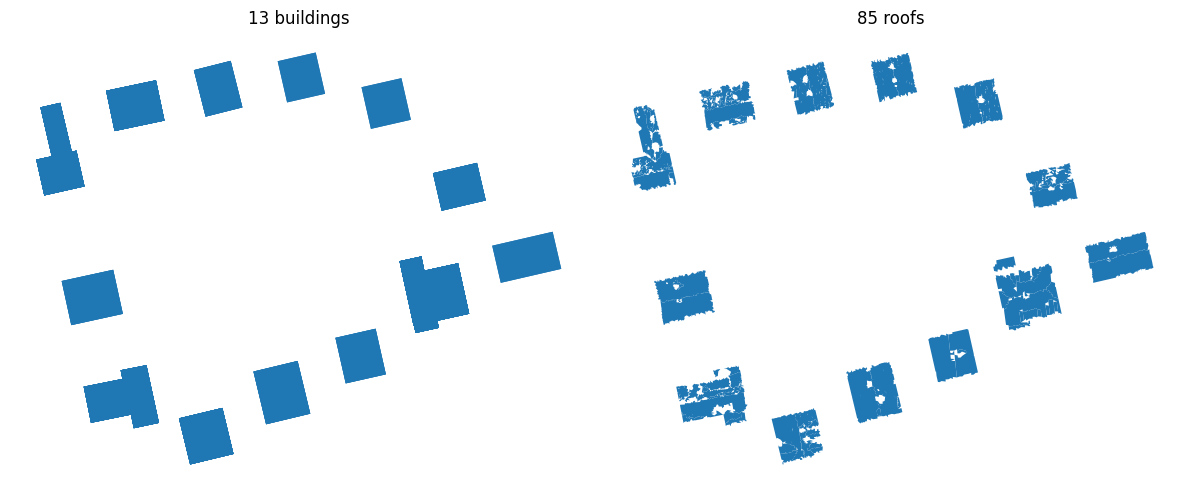

In [18]:
# plot buildings and roofs next to each other
fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), nrows=1, ncols=2, sharex=True, sharey=True)
# buildings
buildings_roofs_quarter_gdf.rename(columns={'geometry_building': 'geometry'}).plot(ax=ax1)
ax1.set_axis_off()
nr_buildings = len(buildings_roofs_quarter_gdf.groupby(['HID'], as_index=False)['HID'].count())
ax1.set_title(f'{nr_buildings} buildings')
buildings_roofs_quarter_gdf.rename(columns={'geometry_roof': 'geometry'}).plot(ax=ax2)
ax2.set_axis_off()
ax2.set_title(f'{len(buildings_roofs_quarter_gdf)} roofs')
plt.tight_layout()
plt.savefig('quarter_building and roof overview.png')
plt.show()

In [ ]:
buildings_quarter_gdf.plot(linewidth = 1, edgecolor = 'black', facecolor='lightgrey')

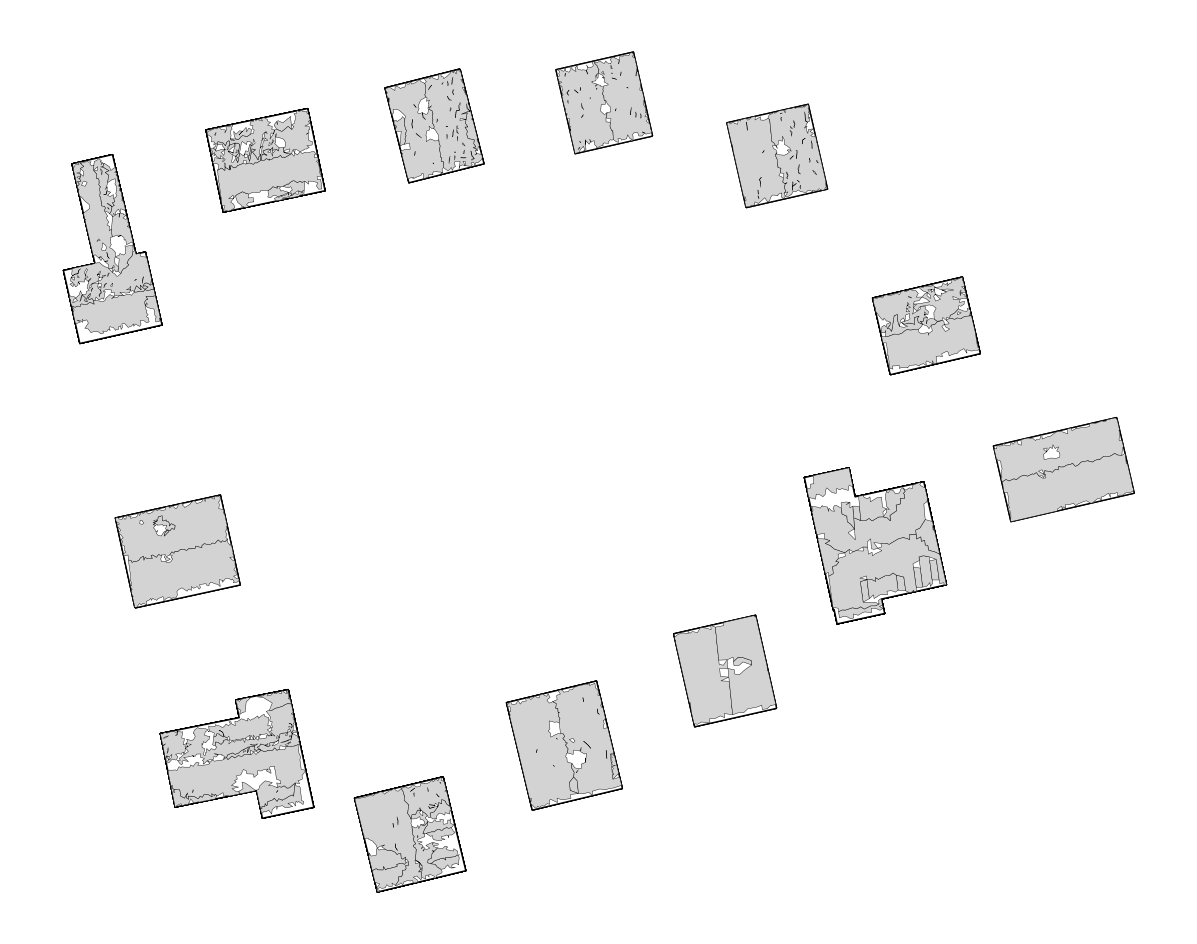

In [51]:
fig, ax = plt.subplots(figsize = (16,12))
buildings_roofs_quarter_gdf.rename(columns={'geometry_building': 'geometry'}).plot(ax = ax, linewidth = 1, edgecolor = 'black', facecolor='white')
buildings_roofs_quarter_gdf.rename(columns={'geometry_roof': 'geometry'}).plot(ax = ax, linewidth = .3, edgecolor = 'black', facecolor='lightgrey')
ax.set_axis_off()
plt.show()

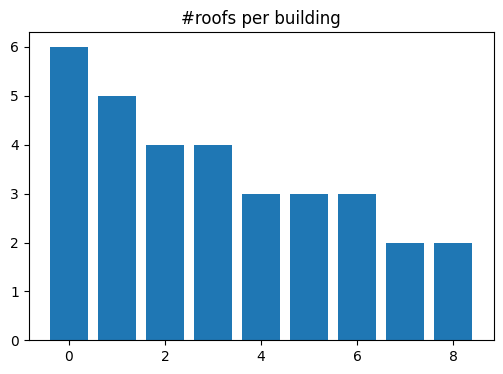

In [13]:
roofs_per_building = buildings_roofs_quarter_gdf.groupby(['HID'], as_index=False)['HID'].count().sort_values(by='HID',
                                                                                                             ascending=False)
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x=roofs_per_building.index.sort_values(), height=roofs_per_building.HID)
ax.set_title('#roofs per building')
plt.show()

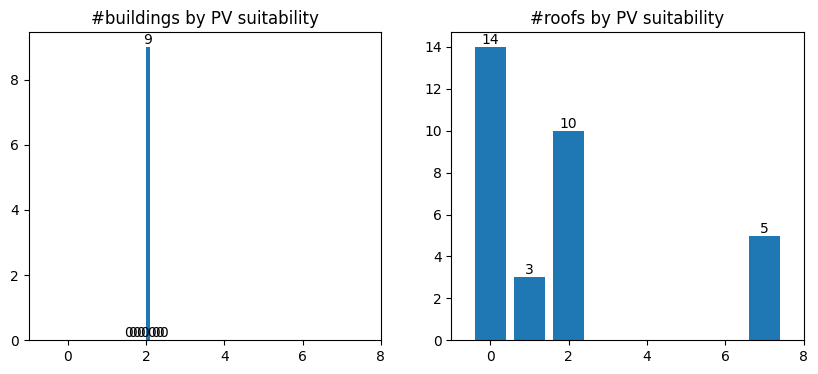

In [14]:
pv_suitability_buildings = buildings_roofs_quarter_gdf.groupby(['HID'], as_index=False)[
    'PV_building'].mean().sort_values(by='PV_building', ascending=False)
pv_suitability_roofs = buildings_roofs_quarter_gdf.groupby(['PV_roof'], as_index=False)['HID'].count().sort_values(
    by='HID', ascending=False)

fig, (ax1, ax2) = plt.subplots(figsize=(10, 4), sharey=False, sharex=True, ncols=2, nrows=1)
ax1.hist(pv_suitability_buildings.PV_building)
ax1.set_title('#buildings by PV suitability')
ax1.bar_label(ax1.containers[0], label_type='edge')
ax1.set_xlim([-1, 8])
ax2.bar(x=pv_suitability_roofs.PV_roof, height=pv_suitability_roofs.HID)
ax2.set_title('#roofs by PV suitability')
ax2.bar_label(ax2.containers[0], label_type='edge')
plt.show()

C:\Users\joche\AppData\Local\Temp\ipykernel_2864\1674425325.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pv_suitable_buildings = buildings_roofs_quarter_gdf[buildings_roofs_quarter_gdf.PV_roof > 0].groupby(['HID'], as_index=False)['AREA3D_roof','GLOBAL'].sum()
C:\Users\joche\AppData\Local\Temp\ipykernel_2864\1674425325.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pv_suitable_buildings_agg = pv_suitable_buildings.groupby(['HID'], as_index=False)['HID', 'TOTAL_KWHPA'].sum().sort_values(by='TOTAL_KWHPA', ascending=False)


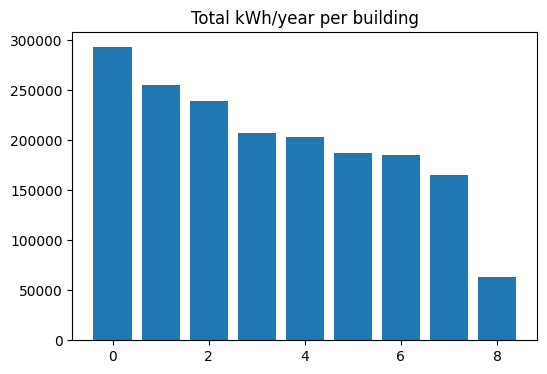

In [15]:
# filter out unsuitable roofs for PV
pv_suitable_buildings =
buildings_roofs_quarter_gdf[buildings_roofs_quarter_gdf.PV_roof > 0].groupby(['HID'], as_index=False)[
    'AREA3D_roof', 'GLOBAL'].sum()
pv_suitable_buildings['TOTAL_KWHPA'] = pv_suitable_buildings.AREA3D_roof * pv_suitable_buildings.GLOBAL
pv_suitable_buildings_agg = pv_suitable_buildings.groupby(['HID'], as_index=False)[
    'HID', 'TOTAL_KWHPA'].sum().sort_values(by='TOTAL_KWHPA', ascending=False)
# plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x=pv_suitable_buildings_agg.index.sort_values(), height=pv_suitable_buildings_agg.TOTAL_KWHPA)
ax.set_title('Total kWh/year per building')
plt.show()

In [21]:
buildings_quarter_gdf

,HID,STREET,NUMBER,ADDITION,ZIPCODE,CITY,AREA,AREA3D,PV,ST,geometry
42074,12713,Föhrenweg,6.0,None,85049,Ingolstadt,98.89350,164.200562,2,2,"POLYGON ((674905.370 5405177.730, 674914.910 5..."
47661,12716,Altenhofstr.,17.0,1/2,85049,Ingolstadt,110.46910,127.561109,2,2,"POLYGON ((674929.560 5405177.580, 674924.880 5..."
49895,13230,Lärchenweg,6.0,1/2,85049,Ingolstadt,121.21780,142.058181,2,2,"POLYGON ((674882.430 5405204.320, 674885.050 5..."
52582,13250,Altenhofstr.,19.0,a,85049,Ingolstadt,87.47910,185.622052,2,2,"POLYGON ((674906.020 5405192.770, 674906.740 5..."
55624,13236,Lärchenweg,6.0,None,85049,Ingolstadt,111.06345,154.478034,2,2,"POLYGON ((674872.430 5405184.760, 674877.500 5..."
61547,12700,Lärchenweg,4.0,1/2,85049,Ingolstadt,102.98355,178.067077,2,2,"POLYGON ((674871.730 5405159.750, 674872.200 5..."
61552,12707,Föhrenweg,4.0,None,85049,Ingolstadt,86.70510,108.434329,2,2,"POLYGON ((674901.420 5405171.260, 674891.990 5..."
61804,12717,Lärchenweg,8.0,None,85049,Ingolstadt,139.35180,320.893786,2,2,"POLYGON ((674844.710 5405210.050, 674859.590 5..."
61853,13253,Altenhofstr.,19.0,None,85049,Ingolstadt,80.66775,135.439341,2,2,"POLYGON ((674915.620 5405201.100, 674914.100 5..."


C:\Users\joche\anaconda3\envs\abm\lib\site-packages\libpysal\weights\gabriel.py:134: UserWarning: The numba package is used extensively in this module to accelerate the computation of graphs. Without numba, these computations may become unduly slow on large data.
  warnings.warn("The numba package is used extensively in this module"


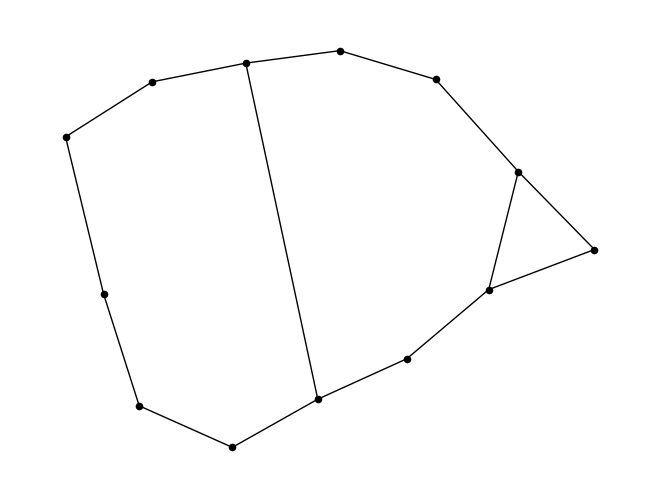

In [28]:
export_gdf = gpd.GeoDataFrame(export, crs='EPSG:25832', geometry=export.geometry)
centroids = np.column_stack((export_gdf.centroid.x, export_gdf.centroid.y))
graph = weights.Gabriel.from_dataframe(export_gdf.centroid)
network = graph.to_networkx()
positions = dict(zip(network.nodes, centroids))
nx.draw(network, positions, node_size=20, node_color='black')

In [29]:
# extract the centroids for connecting the regions, which is
# the average of the coordinates that define the polygon's boundary
centroids = np.column_stack((buildings_quarter_gdf.centroid.x, buildings_quarter_gdf.centroid.y))
# construct the "Gabriel network" graph
graph = weights.Gabriel.from_dataframe(buildings_quarter_gdf.centroid)
# convert graph to network
network = graph.to_networkx()
# merge nodes to positions for plotting
positions = dict(zip(network.nodes, centroids))

C:\Users\joche\anaconda3\envs\abm\lib\site-packages\libpysal\weights\gabriel.py:134: UserWarning: The numba package is used extensively in this module to accelerate the computation of graphs. Without numba, these computations may become unduly slow on large data.
  warnings.warn("The numba package is used extensively in this module"


In [18]:
type(network)

networkx.classes.graph.Graph

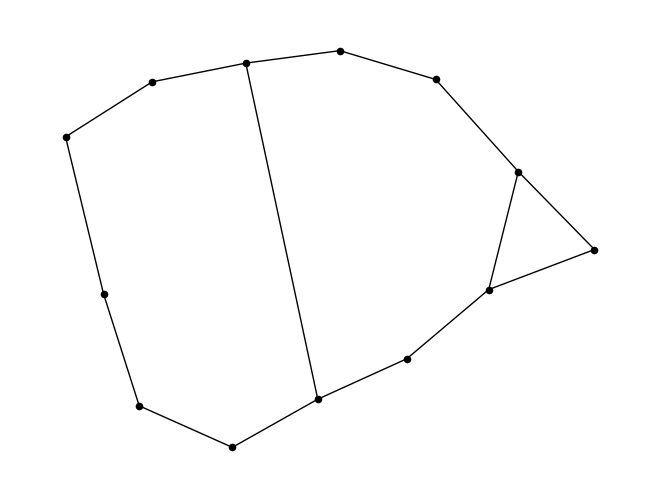

In [30]:
nx.draw(network, positions, node_size=20, node_color='black')

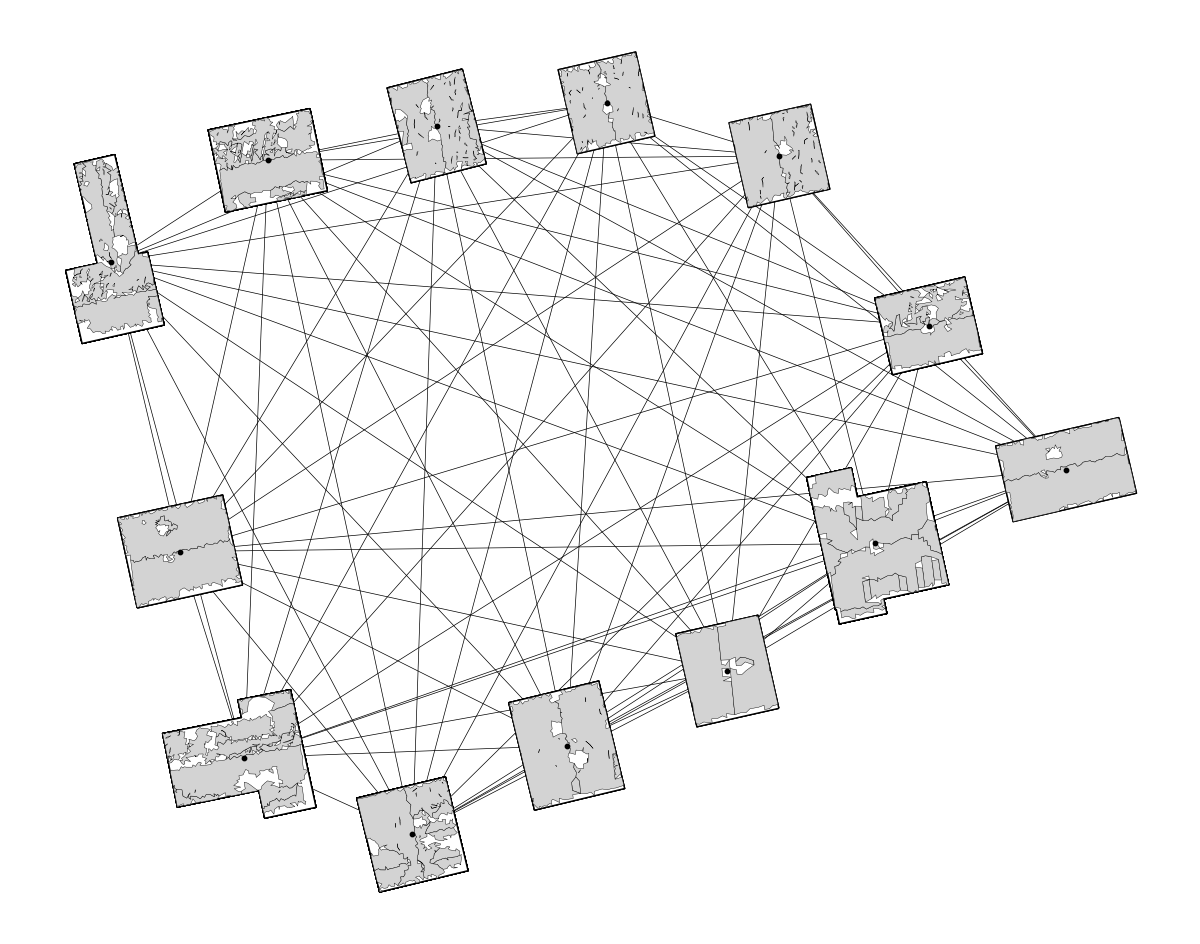

In [94]:
fig, ax = plt.subplots(figsize = (16,12))
G = nx.complete_graph(network)
#nx.draw(nx.complete_graph(network), positions, node_size=20, node_color='black', )
nx.draw_networkx_nodes(G, positions, nodelist=G.nodes, node_size=10, node_color='black')
nx.draw_networkx_edges(G, positions, edgelist=G.edges, edge_color = 'black', width=.5)
buildings_roofs_quarter_gdf.rename(columns={'geometry_building': 'geometry'}).plot(ax = ax, linewidth = 1, edgecolor = 'black', facecolor='white')
buildings_roofs_quarter_gdf.rename(columns={'geometry_roof': 'geometry'}).plot(ax = ax, linewidth = .3, edgecolor = 'black', facecolor='lightgrey')
ax.set_axis_off()
plt.show()

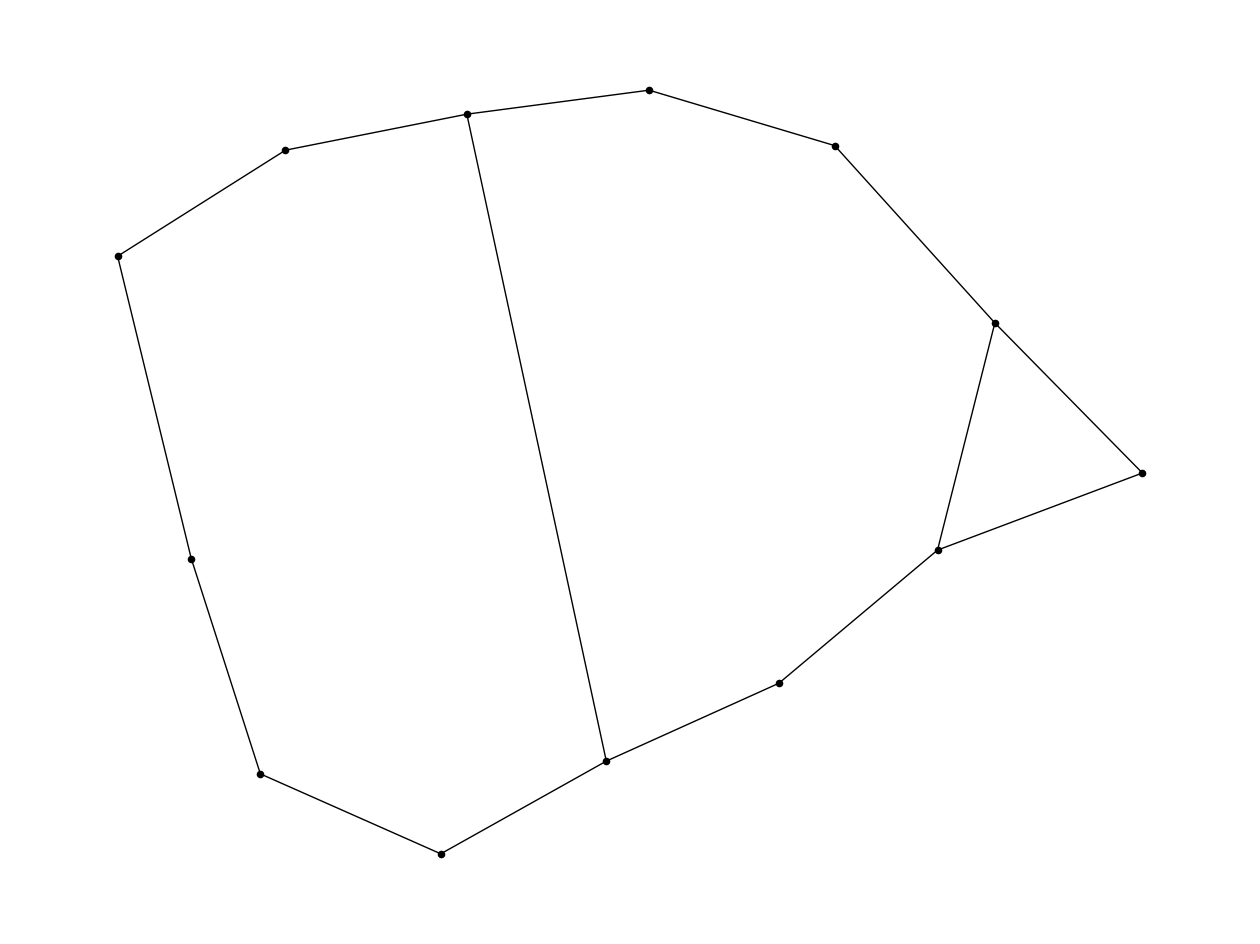

In [58]:
fig, ax = plt.subplots(figsize = (16,12))
nx.draw(network, positions, node_size=20, node_color='black', ax = ax)
plt.show()